# アンサンブル＋最頻値  
学習データは時系列データ  
学習はランダムのデータを使う  
テストはvalidationのデータを使う

In [37]:
import os
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn import decomposition
from sklearn import preprocessing
from sklearn import manifold
from sklearn import metrics
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import urllib.request
import shutil
import zipfile
from scipy.stats import mode

In [40]:
fold = "../train_random_20000/"
# .npyファイルからデータをロード
x = np.load(f'{fold}x.npy')
label = np.load(f"{fold}label.npy")

# データの形状を表示
print("Shape of the loaded x data:", x.shape)
print("Shape of the loaded label data:", label.shape)

Shape of the loaded x data: (20000, 500)
Shape of the loaded label data: (20000,)


In [41]:
print(pd.Series(label).value_counts())

7.0    3261
5.0    3193
6.0    2924
1.0    2507
2.0    2491
4.0    2422
8.0    2349
3.0     853
Name: count, dtype: int64


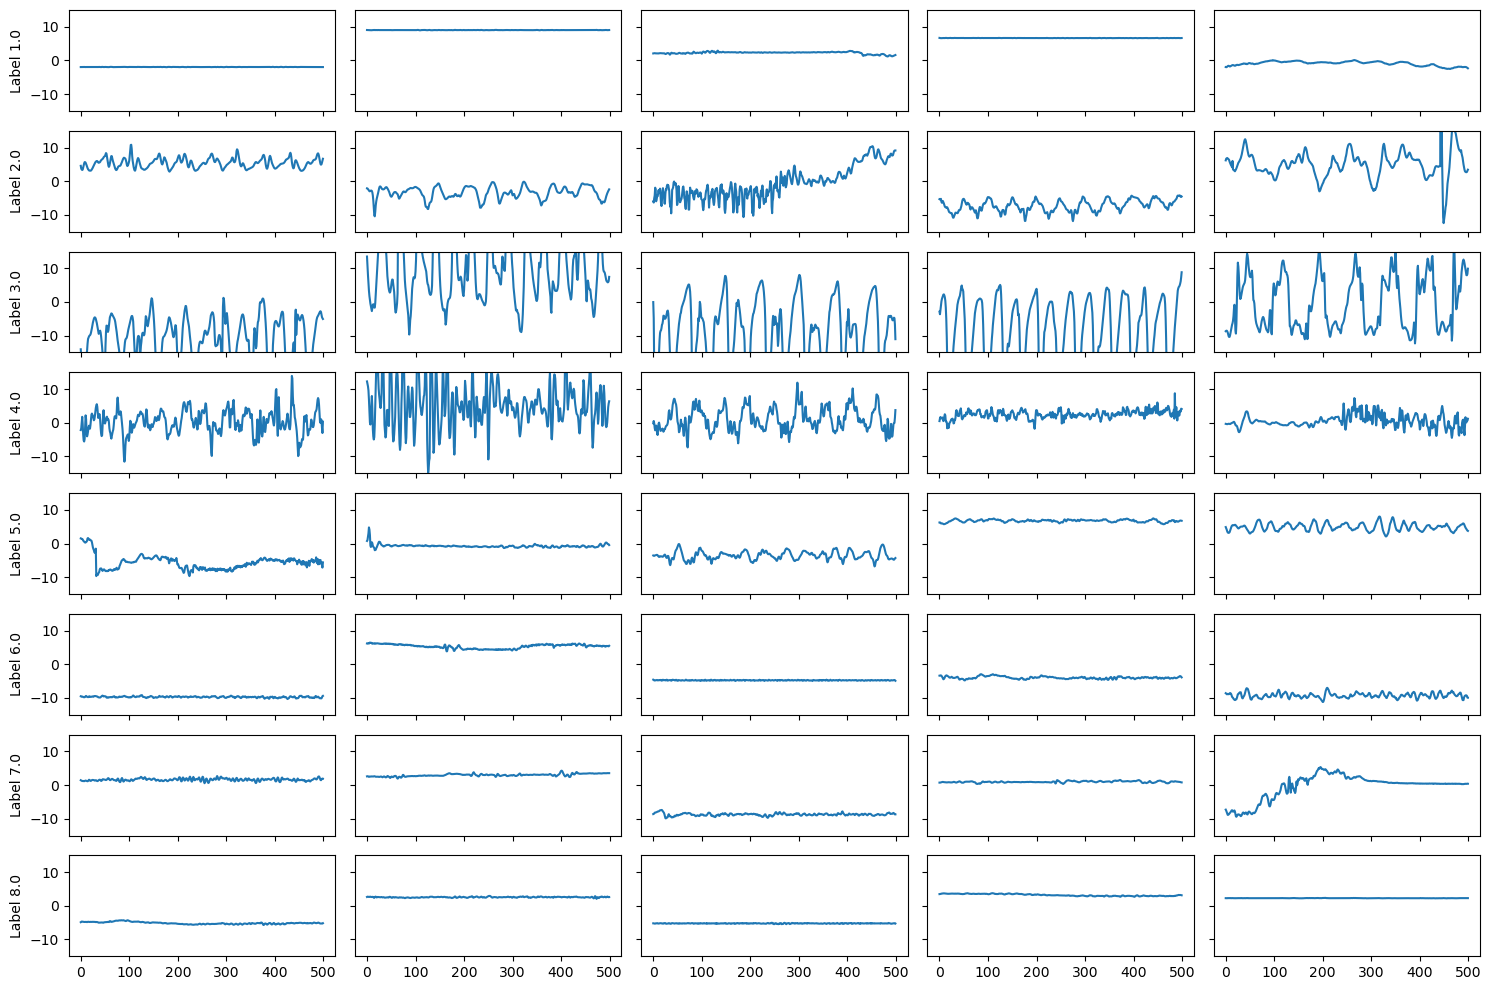

In [42]:
# 一意なラベルを取得
unqY = np.unique(label)

# 各アノテーションについて5つのグラフを描画
NPLOTS = 5
fig, axs = plt.subplots(len(unqY), NPLOTS, sharex=True, sharey=True, figsize=(15, 10))

# 各ラベルについてのプロット
for y, row in zip(unqY, axs):
    indices = np.where(label == y)[0]
    
    # サンプリングインデックス数がNPLOTS未満の場合の対応
    if len(indices) < NPLOTS:
        sampled_indices = indices
    else:
        sampled_indices = np.random.choice(indices, size=NPLOTS, replace=False)
    
    row[0].set_ylabel(f'Label {y}')
    for x_data, ax in zip(x[sampled_indices], row):
        ax.plot(x_data)
        ax.set_ylim(-15, 15)

fig.tight_layout()
plt.show()

In [24]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(x, label, train_size=16000, shuffle=False)

In [25]:
test_y

array([6., 6., 6., ..., 3., 3., 3.])

In [26]:
# 分割後のデータの形状を表示
print("Shape of train_x:", train_x.shape)
print("Shape of test_x:", test_x.shape)
print("Shape of train_y:", train_y.shape)
print("Shape of test_y:", test_y.shape)

Shape of train_x: (16000, 500)
Shape of test_x: (4000, 500)
Shape of train_y: (16000,)
Shape of test_y: (4000,)


In [21]:
np.unique(train_y)

array([1., 2., 3., 4., 6., 7., 8.])

In [22]:
train_y.shape

(16000,)

In [23]:
clf = BalancedRandomForestClassifier(
    n_estimators=2000,
    replacement=True,
    sampling_strategy='not minority',
    oob_score=True,
    n_jobs=8,
    random_state=42,
    verbose=1
)
clf.fit(train_x,train_y) # 訓練データを使ってまずランダムフォレストを学習している。

c:\Users\kaiha\anaconda3\envs\labo_Okita\lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   10.5s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   25.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:   44.9s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:  1.2min
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:  1.8min
[Parallel(n_jobs=8)]: Done 2000 out of 2000 | elapsed:  2.0min finished


BalancedRandomForestClassifier(n_estimators=2000, n_jobs=8, oob_score=True,
                               random_state=42, replacement=True,
                               sampling_strategy='not minority', verbose=1)

以下はこれからのために取っておく

In [9]:
Y_test_pred = clf.predict(test_x) # 学習器の性能をみる テストデータで
print('\nClassifier performance')
print('Out of sample:\n', metrics.classification_report(test_y, Y_test_pred, zero_division=0))

# This will be the training set
Y_in_train = clf.oob_decision_function_.astype('float32') # OOBデータを用いて予測。結果をY_in_trainに入れている。
# This will be the test set
Y_in_test = clf.predict_proba(X_test).astype('float32') # クラス所属確率の予測も入っている。Y_test_predとは違って他のクラスへの所属確率も出力している点に留意

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.5s



Classifier performance
Out of sample:
               precision    recall  f1-score   support

         1.0       0.52      0.52      0.52       466
         2.0       0.54      0.71      0.61       424
         3.0       0.74      0.94      0.83       200
         4.0       0.76      0.70      0.73       516
         6.0       0.38      0.40      0.39       500
         7.0       0.62      0.59      0.60      1117
         8.0       0.41      0.34      0.37       777

    accuracy                           0.55      4000
   macro avg       0.57      0.60      0.58      4000
weighted avg       0.55      0.55      0.55      4000



[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 2000 out of 2000 | elapsed:    0.9s finished


"\n# This will be the training set\nY_in_train = clf.oob_decision_function_.astype('float32') # OOBデータを用いて予測。結果をY_in_trainに入れている。\n# This will be the test set\nY_in_test = clf.predict_proba(X_test).astype('float32') # クラス所属確率の予測も入っている。Y_test_predとは違って他のクラスへの所属確率も出力している点に留意"

In [102]:
np.unique(test_y)

array([1., 2., 3., 4., 6.])

In [11]:
Y_test_pred

array([6., 2., 8., ..., 4., 4., 4.])

In [27]:
Y_test_pred = clf.predict(test_x)
print('\nClassifier performance')
print('Out of sample:\n', metrics.classification_report(test_y, Y_test_pred))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.6s



Classifier performance
Out of sample:
               precision    recall  f1-score   support

         1.0       0.83      0.82      0.82       396
         2.0       0.90      0.94      0.92       462
         3.0       0.99      0.98      0.99       579
         4.0       0.96      0.95      0.95       629
         6.0       0.99      0.82      0.89      1934
         7.0       0.00      0.00      0.00         0
         8.0       0.00      0.00      0.00         0

    accuracy                           0.88      4000
   macro avg       0.67      0.64      0.65      4000
weighted avg       0.96      0.88      0.91      4000



[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 2000 out of 2000 | elapsed:    1.0s finished
c:\Users\kaiha\anaconda3\envs\labo_Okita\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kaiha\anaconda3\envs\labo_Okita\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kaiha\anaconda3\envs\labo_Okita\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zer

In [28]:
import scipy.stats as stats

def mode(alist): # 与えられたリストの最頻値を計算する。　複数ある場合はリストの中央値を返す
    ''' Mode of a list, but return middle element if ambiguous '''
    m, c = stats.mode(alist) # mは最頻値 cは最頻値の出現回数
    m, c = m.item(), c.item()
    if c==1:
        return alist[len(alist)//2]
    return m

def rolling_mode(t, y, window_size='100S'): # インデックスの時間ｔ、ラベルのｙ、そしてwindow_sizeを1005にする。　yのアノテーションを更新したy_smoothを返す。滑らかなアノテーションになっているはず
    y_dtype_orig = y.dtype
    # Hack to make it work with pandas.Series.rolling()
    y = pd.Series(y, index=t, dtype='category')
    y_code_smooth = y.cat.codes.rolling(window_size).apply(mode, raw=True).astype('int') # rollingでyのデータをウィンドウ化してapplyで関数を適用。それをintに変換する。カテゴリカルコードはテキストも数値に変える（英語のみかも）
    y_smooth = pd.Categorical.from_codes(y_code_smooth, dtype=y.dtype) #　ここでカテゴリカルコード（数値データ）からテキストデータ(オブジェクトでーた）に変換される
    y_smooth = np.asarray(y_smooth, dtype=y_dtype_orig)
    return y_smooth

In [31]:
import scipy.stats as stats

def mode(alist):
    m,c = stats.mode(alist) # mは最頻値、cは最頻値の出現回数
    m,c = m.item(), c.item()
    if c == 1:
        return alist[len(alist)//2] # つまり最頻値が決められない場合真ん中の値をとるということ
    return m

def rolling_mode(y, window_size=1500): # ラベルy
    y_dtype_origin = y.dtype
    y = pd.Series(y, dtype='category')

    y_code_smooth = y.cat.codes.rolling(window_size).apply(mode,raw=True)

    #NaNを元の値で埋める
    y_code_smooth = y_code_smooth.fillna(y.cat.codes)

    # intに変換
    y_code_smooth = y_code_smooth.astype('int')
    
    y_smooth = pd.Categorical.from_codes(y_code_smooth, dtype=y.dtype)
    y_smooth = np.asarray(y_smooth, dtype=y_dtype_origin)
    return y_smooth

In [32]:
train_y

array([4., 4., 4., ..., 6., 6., 6.])

In [33]:
Y_test_pred_smooth = []
Y_test_pred_smooth.append(rolling_mode(Y_test_pred,window_size=6))

In [34]:
Y_test_pred_smooth = np.concatenate(Y_test_pred_smooth)

In [35]:
print(test_y)

[6. 6. 6. ... 3. 3. 3.]


In [36]:
print('\nClassifier performance -- mode smoothing')
print('Out of sample:\n', metrics.classification_report(test_y, Y_test_pred))
print('Out of sample:\n', metrics.classification_report(test_y, Y_test_pred_smooth))


Classifier performance -- mode smoothing
Out of sample:
               precision    recall  f1-score   support

         1.0       0.83      0.82      0.82       396
         2.0       0.90      0.94      0.92       462
         3.0       0.99      0.98      0.99       579
         4.0       0.96      0.95      0.95       629
         6.0       0.99      0.82      0.89      1934
         7.0       0.00      0.00      0.00         0
         8.0       0.00      0.00      0.00         0

    accuracy                           0.88      4000
   macro avg       0.67      0.64      0.65      4000
weighted avg       0.96      0.88      0.91      4000

Out of sample:
               precision    recall  f1-score   support

         1.0       0.92      0.94      0.93       396
         2.0       0.96      0.97      0.96       462
         3.0       0.98      0.99      0.99       579
         4.0       0.99      0.98      0.98       629
         6.0       0.99      0.95      0.97      1934
    

c:\Users\kaiha\anaconda3\envs\labo_Okita\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kaiha\anaconda3\envs\labo_Okita\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kaiha\anaconda3\envs\labo_Okita\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kaiha\anaconda3\envs\l